# Conjunto de Datos de Telco Customer Churn

Este conjunto de datos, proporcionado en los [IBM Sample Data Sets], está enfocado en el análisis del comportamiento de los clientes para desarrollar programas de retención enfocados. El propósito principal de este dataset es **predecir el comportamiento de los clientes** para retenerlos. Permite el análisis exhaustivo de datos relevantes del cliente y ayuda en la creación de programas de retención de clientes específicos.

## Contenido del Dataset

- **Churn**: Indica si el cliente abandonó la compañía en el último mes.
- **Servicios**: Detalla los servicios que cada cliente ha contratado, incluyendo:
  - Telefonía
  - Líneas múltiples
  - Internet
  - Seguridad en línea
  - Backup en línea
  - Protección de dispositivos
  - Soporte técnico
  - Streaming de TV y películas
- **Información de la cuenta del cliente**: Abarca la duración como cliente, tipo de contrato, método de pago, facturación sin papel, cargos mensuales y cargos totales.
- **Información demográfica**: Incluye género, rango de edad, y si tienen pareja y dependientes.

Para acceder a la versión más reciente del conjunto de datos proporcionada por IBM, visite el siguiente enlace: [IBM Community](https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113).




# Rubrica de evaluación

| Criterios                                                                                                               | Si | No | Observaciones |
|------------------------------------------------------------------------------------------------------------------------|----|----|---------------|
| El documento reporta la selección de las dos hipótesis más adecuadas                                                    | -   | -   |  -             |
| El documento reporta argumentos a favor de la selección de cada hipótesis elegida                                       | -   | -   |  -             |
| El documento reporta argumentos en contra de las hipótesis no seleccionadas                                             | -   | -   |    -           |
| El documento reporta la realización de la etapa de entendimiento de los datos para identificar si los supuestos hechos en la hipótesis sobre ellos son reales. |  -  |  -  |     -          |
| El documento enuncia los parámetros e hiperparámetros que deben ser estimados para el buen funcionamiento de cada técnica elegida. |  -  |  -  |     -          |
| El documento establece claramente cuál es la entrada y la salida de cada modelo y analiza si es necesario realizar ajustes en la representación de los datos para que la técnica esté en capacidad de recibir esa entrada y producir esa salida. | -   |  -  |         -      |


# Libraries

A continuación, se listan las librerías y clases que se utilizarán para el desarrollo del ejercicio propuesto en el presente documento:

In [37]:
import time
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from sklearn.svm import SVC
from scipy import stats
import plotly.express as px
from sklearn.utils import resample
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.preprocessing import StandardScaler
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV # Grid search cross validation
from sklearn.model_selection import RandomizedSearchCV # Random search cross validation



## Etapa 1: Entedimientos de los datos

Los datos a desarrollar en el ejercicio propuesto se encuentran en el siguiente enlace: https://www.kaggle.com/datasets/blastchar/telco-customer-churn. Tambien se encuentran disponibles en un repositorio de Github, para lo cual se escribe el siguiente script para agilizar la conexión a la fuente de datos y la carga respectiva en este documento de Colab:



In [ ]:
!git clone https://github.com/IBM/telco-customer-churn-on-icp4d/
%cd telco-customer-churn-on-icp4d

Se hace la carga de datos y se verifica que los datos se hayan cargado correctamente. En efecto, se puede notar la variable objetivo del ejercicio **Churn** en la ultima columna del dataset, acompañada de un total de 20 atributos. Se aprecia tambien que se compone de un total de 7042 observaciones:

In [3]:
#df = pd.read_csv("/content/telco-customer-churn-on-icp4d/data/Telco-Customer-Churn.csv")
df = pd.read_csv("data/Telco-Customer-Churn.csv")
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['SeniorCitizen'] = df['SeniorCitizen'].astype('object')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Tipo de variables:

* customerID

Es una variable de tipo ID compuesta por 4 caractéres numéricos y 4 alfabeticos separadas por "-".

* gender:

Variable categórica, de texto. Salidas: "Male" o "Female". Hace referencia al género del suscriptor o abonado. Se distribuye en 50% para "Male" y 50% para "Female".

* SeniorCitizen:

Hace referencia a si el suscriptor es un adulto mayor. Variable binaria, categórica nominal, salidas de 1 para sí es adulto mayor y 0 para lo contrario. Del total de 7042 registros, tiene 1142 en 1 y el resto en cero. Teóricamente se considera que los adultos mayores son más reacios a cambiar su proveedor de Telco.

* Partner

Hace referencia a si el suscriptor tiene o no pareja. Variable categórica nominal, con valores de salida de "Yes" para sí tiene pareja y "No" para no tiene pareja.

* Dependents

Hace referencia a si el suscriptor tiene o no personas a cargo. Variable categórica nominal, con valores de salida de "Yes" para sí tiene personas a cargo y "No" para no tiene personas a cargo. Si tienen dependientes

* tenure

Hace referencia al número de periodos en meses en que el suscriptor ha estado con la compañía de Telco. Es una variable tipo "integer" con valores que van desde cero hasta 72.

* PhoneService

Hace referencia a si el suscriptor tiene o no servicio de teléfono. Variable categórica nominal, con valores de salida de "Yes" para sí tiene servicio de teléfono y "No" para no tiene Servicio de teléfono.

* MultipleLines

Hace referencia a si el suscriptor tiene múltiples líneas telefónicas. Variable Categórica nominal con tres categorías: "Yes", para sí tiene múltiples líneas telefónicas, "No" para no tiene múltiples líneas telefónicas, y "No phone service" para el hecho que no tenga contratado el servicio de teléfono.

* InternetService

Hace referencia al tipo de servicio de internet que tiene el suscriptor. Variable categórica nominal con tres categorías de salida: "DSL", para suscriptores que tienen este tipo de tecnología en su conexión de internet, "Fiber optic" para suscriptores que tienen conexión por fibra óptica, y "No" para suscriptores o abonados que no tienen contratado el servicio de internet.

* OnlineSecurity

Hace referencia a si el suscriptor tiene o no servicio de seguridad en línea. Variable categórica nominal, con valores de salida de "Yes" para sí tiene servicio de seguridad en línea, "No" para no tiene servicio de seguridad en línea y "No internet service" para quienes no tienen el servicio de internet. (Asumimos que son valores agregados que brindan las compañías como filtros de spam, phishing, controles parentales, o cortafuegos)

* OnlineBackup  

Hace referencia a si el suscriptor tiene o no servicio de respaldo de información en línea. Variable categórica nominal, con valores de salida de "Yes" para sí tiene servicio de respaldo de información en línea, "No" para no tiene servicio de respaldo de información en línea y "No internet service" para quienes no tienen el servicio de internet.


* DeviceProtection

Hace referencia a si el suscriptor tiene o no servicio de protección de dispositivos. Variable categórica nominal, con valores de salida de "Yes" para sí tiene servicio de protección de dispositivos, "No" para no tiene servicio de protección de dispositivos y "No internet service" para quienes no tienen el servicio de internet.. (Asumimos que son valores agregados que brindan las compañías como seguros para los dispositivos como celulares, tablets o pcs que van a estar utilizando los servicios)


* TechSupport

Hace referencia a si el suscriptor tiene o no servicio de soporte técnico. Variable categórica nominal, con valores de salida de "Yes" para sí tiene servicio de soporte técnico, "No" para no tiene servicio de soporte técnico y "No internet service" para quienes no tienen el servicio de internet. (Asumimos que son valores agregados que brindan las compañías como seguros para los dispositivos como celulares, tablets o pcs que van a estar utilizando los servicios)

* StreamingTV

Hace referencia a si el suscriptor tiene o no servicio de "Streaming TV". Variable categórica nominal, con valores de salida de "Yes" para sí tiene servicio "Streaming TV", "No" para no tiene servicio de "Streaming TV" y "No internet service" para quienes no tienen el servicio de internet. (Hace referencia a tener acceso a canales de televisión que puedan ser visualizados por dispositivos compatibles conectados a internet)


* StreamingMovies

Hace referencia a si el suscriptor tiene o no servicio de plataformas de películas por streaming. Variable categórica nominal, con valores de salida de "Yes" para sí tiene servicio plataformas de películas por streaming, "No" para no tiene servicio de plataformas de películas por streaming y "No internet service" para quienes no tienen el servicio de internet. (Hace referencia a acceso de películas por streaming, como plataformas tipo Nextflix, Prime Video o Disney +)

* Contract            

Hace referncia al tipo de contrato que tiene el suscriptor con la empresa. Es una variable categórica nominal que tiene las siguientes salidas: "Month-to-month" para referirse a los clientes que no tienen una permanencia mínima. "One year", para clientes que tienen un contrato fijo por el término de un año y "Two year" para suscriptores cuya permanencia en el contrato es por dos años.  


* PaperlessBilling

Hace referencia a si el suscriptor tiene o no factura sin uso de papel (Enviada por correo electrónico), o mejor, que no tiene factura física. Variable categórica, con valores de salida de "Yes" para los suscriptores que no tienen factura física "No" para los clientes que tienen de factura física o convencional

* PaymentMethod

Hace referencia al método de pago que usa el suscriptor. Variable categórica nominal con las siguientes posibles salidas: Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic).


* MonthlyCharges

Hace referencia a los cargos que se facturan con una periodicidad mensual al suscriptor. Es una variable numérica contínua.


* TotalCharges

Hace referencia al total del cargos facturados al suscriptor. Es una variable numérica, con valores que van desde 18.8 hasta 8.68k. Los valores más altos hacen referencia a los suscriptores que más tiempo de permanencia llevan con la compañía.  


* Churn

Es nuestra variable respuesta, objeto del estudio. Salida de "Yes" o "No" para el suscriptor que se haya desvinculado de la empresa de telecomunicaciones y "No" los clientes que siguen con el servicio contratado.

In [4]:
df.dtypes

customerID           object
gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [5]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

Procedemos con el método info, con el objetivo de buscar valores nulos en alguna de las variables del dataset:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Al respecto y teniendo en cuenta que el número de registros es de 7043, encontramos que una de las variables, "TotalCharges" tiene diferencias con el total de registros, dado que tiene 7032 "non-null". De acuerdo con esto recordamos las dimensiones del dataset:

In [7]:
print("El número de registros es: ", df.shape[0])
print("El número de atributos es: ", df.shape[1])

El número de registros es:  7043
El número de atributos es:  21


COn el método isnull detectamos que en efecto, la variable ´TotalCharges´ registra un total de 11 valores nulos:

In [8]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Para el efecto, se decide hacer una imputación con el valor de la media de la variable, para no perder estas observaciones. Tambien se pudo eliminar las 11 observaciones, dado que no son representativas en comparación con el total de observaciones, pero procedemos con la media de acuerdo con lo definido:

In [9]:
df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

En efecto, con la verificación del método isnull, efectivamente damos cuenta que la imputación de los 11 valores de la variable en cuestión fue efectiva.

## Variables Numéricas

A continuación, procedemos analizando las variables numéricas que componen el dataset, con el método describe:


In [10]:
df.describe().round(3)

,tenure,MonthlyCharges,TotalCharges
count,7043.000,7043.000,7043.000
mean,32.371,64.762,2283.300
std,24.559,30.090,2265.000
min,0.000,18.250,18.800
25%,9.000,35.500,402.225
50%,29.000,70.350,1400.550
75%,55.000,89.850,3786.600
max,72.000,118.750,8684.800


Las variables son "tenure" que de acuerdo con la descripción inicial, hace referencia a la permanencia en meses que lleva el suscriptor observado. Como referfencia inicial, notamos que l amedia se enucetra alrededor de los 32 meses, pero la mediana está en los 29 meses. La distribución de esta variable, como veremos más adelante, nos presenta a cero (0) meses y a 72 meses como las salidas con mayor frecuencia, siendo cero la moda.

Por otro lado, tenemos la variable "MonthlyCharges" que indica que los valores facturados mensualmente a los clientes van desde los 18.25 hasta los 118.75 dólares. Finalmente tenemos los cargos totales facturados a los clientes, que van desde los 18.8 hasta los 8684 USD, asociados a los clientes con mayor nivel de permanencia.

## Variables Categoricas

A Continuación presentamos un análisis de distribución de las varaibles categóricas a partir de un análisis gráfico.

El código propuesto es el siguiente:

In [11]:
categorical_features=df.select_dtypes(include=['object']).columns[1:]
print(categorical_features)

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object')


In [12]:
for variable in categorical_features[:-1]:
    # Histogram
    countplot_fig = px.histogram(df, x=df[variable].value_counts().index, y=df[variable].value_counts().values,title=f'Conteo para {variable}')
    countplot_fig.update_traces(texttemplate='%{y}', textposition='outside')
    countplot_fig.update_xaxes(categoryorder='total ascending')
    # Pie chart
    counts = df[variable].value_counts()
    labels = counts.index
    pie_chart_fig = px.pie(names=labels, values=counts, title=f'Gráfico de Torta para {variable}',
                        labels={'names': '', 'values': ''},
                        hole=0.3)

    # Mostrar leyenda al pie chart usando las etiquetas del índice
    pie_chart_fig.update_traces(textinfo='percent+label', pull=[0.05]*len(labels))

    # Guardar y mostrar la figura

    countplot_fig.write_html(f"{variable}_countplot.html")
    pie_chart_fig.write_html(f"{variable}_pie_chart.html")
    countplot_fig.show()
    pie_chart_fig.show()


## Análisis de variables descriptivas

A Continuación, se efectúa el análisis para las variables categóricas que componen este set de datos, de acuerdo con el análisis gráfico presentado anteriormente.

* gender

Dentro de las 7043 observaciones se encuentra que están equidistribuidos. 3488 para "Female" y 3555 para "Male".

* SeniorCitizen

La proporción de adultos mayores dentro del dataset corresponde al 16.2% del total con un total de 1142 observaciones.

* Partner

Los datos para esta variable categórica están relativamente equidistribuidos, con una ligera proporción mas alta de suscriptores que no tienen pareja. 3641 de las observaciones revelan que no tienen pareja, para un 51.7% del total de las observaciones.

* Dependents

La proporción más alta es de suscriptores que no tienen dependientes. Son 4933 de las observaciones, que corresponde al 70% del total de observaciones. Se espera que este tipo de clientes sea más propenso a desvincularse de su proveedor de servicios de telco.

* PhoneService

La proporción más alta es para los suscriptores que sí poseen un tipo de servicio telefónico. Corresponde a 6361 de la totalidad de las observaciones, es decir un 90.3% del total de los datos.

* MultipleLines

En el caso de los clientes que tienen multiplelines, la porporción más alta es la de clientes que no tienen líneas múltiples. Son 3390 del total. La proporción de clientes que no tienen el servicio es coherente con la variable PhoneServices. Así las cosas, del total de clientes, el 48.1% tienen una sola linea, el 42.2% tienen multiples líneas y se mantiene el 9.68% de clientes que no tiene servicio telefónico.

* InternetService

La proporción más alta es la de clientes que tienen servicio de internet por fibra óptica. Son 3096 para un 44% del total de observaciones. La tecnología de conexión por DSL está presente en el 34.4% de los clientes, para un total de 2421 observaciones, mientras que los restantes 1526 no tienen servicio de internet. Esta proporción, que corresponde al 21.7% del total de clientes, la mantendremos en las siguientes variables.

* OnlineSecurity

La proporción más alta de este servicio es de los que no lo poseen, con un conteo total de 3498 clientes. corresponde al 49.7% de los suscriptores.

* OnlineBackup

La proporción más alta de este servicio es de los que no lo poseen. Son un total de 3088 del total de clientes, que corresponde al 43.8% del total de los suscriptores.

* DeviceProtection

La proporción más alta corresponde a los que no cuentan con este servicio. Es un total de 3085 clientes, para una proporción del 43.9% de los clientes.

* TechSupport

La proporción más alta es para los clientes que no cuentan con el servicio de soporte técnico. Corresponde al 49.3% del total de los clientes.

* StreamingTV

La proporción más alta es para los suscriptores que NO poseen el servicio de televisión por Streaming. Correspodne a un total de 2810 clientes, es decir una proporción del 39.9%. No obstante está bien distribuida para los clientes que sí tienen el servicio, con una proporción de 38.4% del total de observaciones y un conteo de 2707 clientes. Los restantes 1526 que son el 21.7% son los que ya se conocen que no tienen servicio de internet.


* StreamingMovies

En el caso de Streaming Movies, la distribución es muy parecida a la de StreamingTV que se acaba de describir. Los suscriptores que no tienen el servicio son 2785, el 39.5% de todos los clientes, mientras que los que sí lo tienesn son el 38.8%, es decir, 2732 del total de clientes. Los restantes son, al igual que el caso anterior, los que no tienen contratado ningún servicio de internet.

* Contract

La proporción más alta corresponde a los clientes que tienen contratos mes a mes, con un total de 55% de los clientes, es decir un total de 3875 observaciones. La segunda proporción son los clientes con contrato a término de dos años, los cuales deben tener ventajas sustanciales a menores precios, dada la permanencia mínima. Son el 24.1% del total de los clientes, es decir 1695 observaciones. Los retantes 1473 tienen contrato a un año.

* PaperlessBilling

La proporción más alta es para los clientes que optaron por la opción de no tener factura física. Corresponde al 59.6% de los clientes, es decir 4171 observaciones totales. Los demás suscriptores reciben su factura en físico (Papel impreso)

* PaymentMethod

En el caso del médio de pago, la proporción mas alta corresponde a "Cheque electrónico", con el 33.6% del total de observaciones. Los demás medios de pago, como "Cheque por correo", "Transferencia bancaria" y "Tarjeta de Crédito" tienen proporciones similares (22.9%, 21.9%, y 21.6% respectivamente).


## Variables Numericas

A continuación, presentamos un análisis descriptivo de las variables numéricas presentes en el Dataset:

In [13]:
numerical_features = df.select_dtypes(include=['number']).columns
print(numerical_features)

Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')


## Correlaciones entre variables numericas - Pearson, Spearman, Kendall

Las variables numéricas del dataset de referencia son las variables "Tenure", que refiere al número de meses de permanencia que llevan los suscriptores con las empresas, los cargos mensuales y la totalidad de ingresos facturados al cliente.

In [14]:
def stars(p):
    """
    Returns a string of asterisks (*) based on the significance level (alpha value) of a statistical test.

    Args:
        p (float): the p-value of the statistical test

    Returns:
        A string of asterisks indicating the significance level, as follows:
        - five asterisks (*****): alpha value is 0.0001 or 0.01% with 99.99% confidence
        - four asterisks (****): alpha value is 0.001 or 0.1% with 99.9% confidence
        - three asterisks (***): alpha value is 0.01 or 1% with 99% confidence
        - two asterisks (**): alpha value is 0.05 or 5% with 95% confidence
        - one asterisk (*): alpha value is 0.1 or 10% with 90% confidence
        - empty string (''): alpha value is greater than or equal to 0.1
    """
    if p < 0.0001:
        return '*****'
    elif p < 0.001:
        return '****'
    elif p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.1:
        return '*'
    else:
        return ''

In [15]:
def plot_correlations(dataframe, corr_methods):
    for method in corr_methods:
        stroke = withStroke(linewidth=2, foreground='black')
        corr_matrix = dataframe.corr(method=method)
        pval_matrix = dataframe.corr(method=lambda x, y: stats.pearsonr(x, y)[1])

        # Create a mask to show only the lower triangle of the matrix
        mask = np.triu(np.ones_like(corr_matrix))
        mask2 = np.tril(np.ones_like(corr_matrix))
        stars_corr = pval_matrix * mask2 + mask
        pval_stars = stars_corr.applymap(stars)
        color_palette = sns.color_palette("Blues")
        with sns.axes_style("whitegrid"):
            f, ax = plt.subplots(figsize=(12, 10))
            ax = sns.heatmap(corr_matrix.round(4),
                            mask=mask,
                            vmax=1,
                            center=0,
                            vmin=-1,
                            square=True,
                            cmap=sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True),
                            linewidths=.5,
                            annot=True,
                            annot_kws={"size": 12},
                            fmt='.2f')
            ax.set_title(f'{method.capitalize()} Correlations Matrix', fontsize=20)
            plt.xticks(fontsize=9)
            plt.yticks(fontsize=9)

            for i, j in itertools.product(range(corr_matrix.shape[0]), range(corr_matrix.shape[0])):
                ax.text(j + 0.5, i + 0.8, pval_stars.iloc[i, j], ha='center', va='center', color='white', fontsize=18,path_effects=[stroke])

            plt.savefig((f'correlation_vi_{method.capitalize()}_triangular_stage.png'), dpi=300, bbox_inches='tight')
            plt.show()

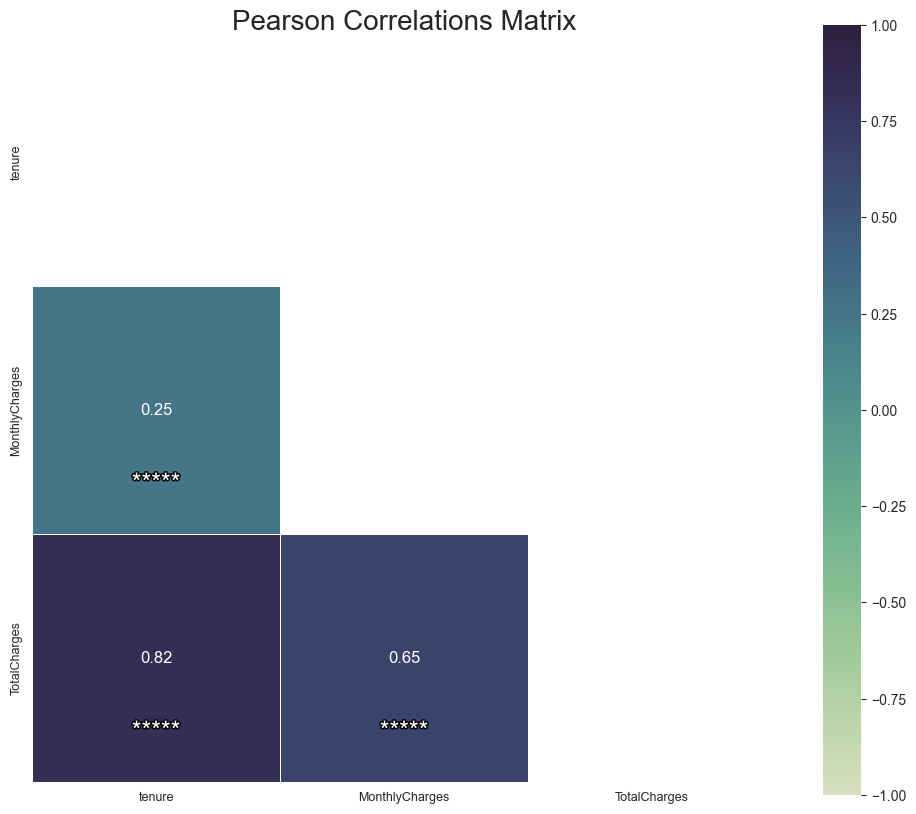

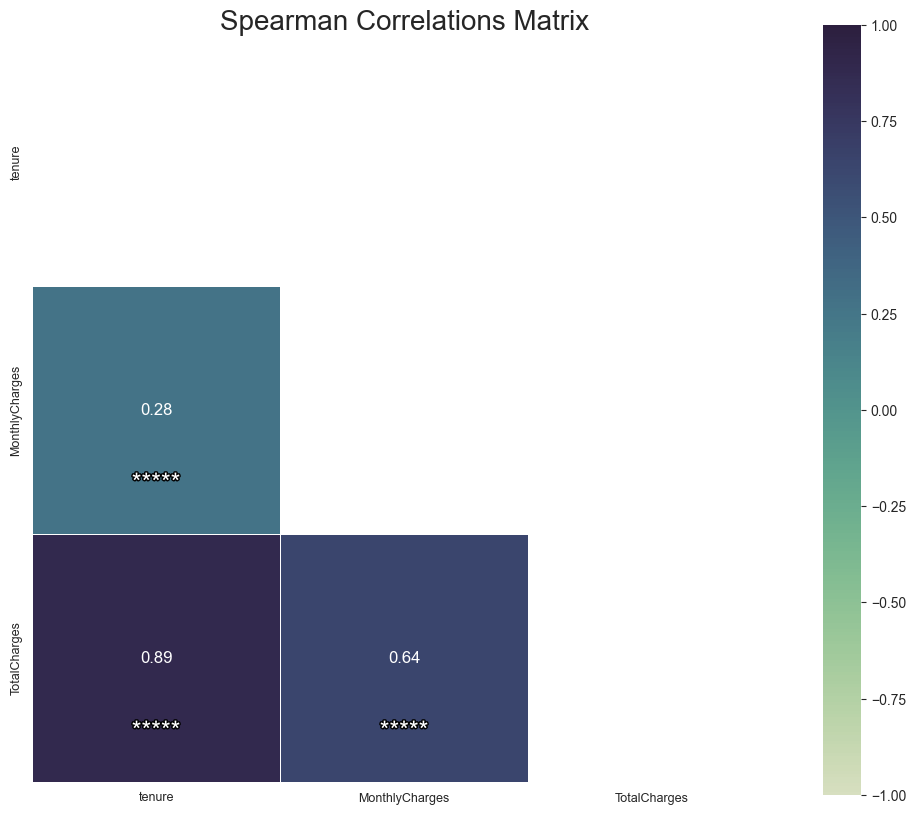

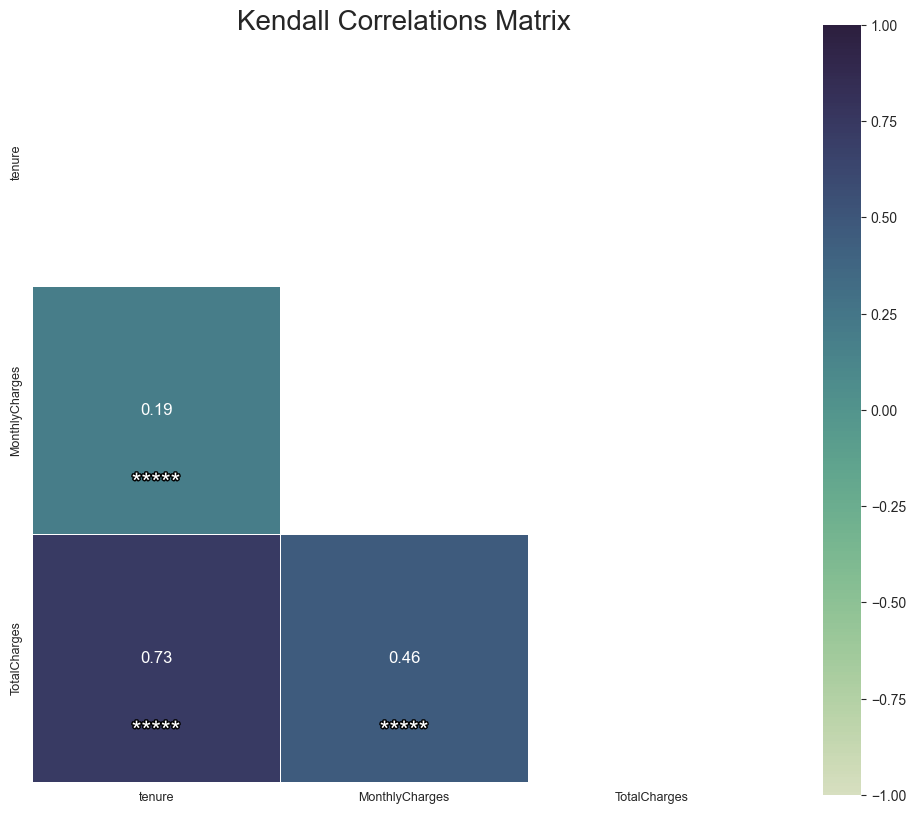

In [16]:
correlation_methods = ['pearson','spearman','kendall']
plot_correlations(df[numerical_features],correlation_methods)

En las tres métricas de correlación evaluadas, todos los coeficientes son significativos.

Se encuentra una correlación fuerte entre la variable "Tenure" y "MonthlyCharges", lo cual tiene lógica dado que a mayor permanencia contratando los servicios de la empresa, mayor es la cantidad de dinero que el suscriptor ha pagado durante la vigencia de la relación contractual.


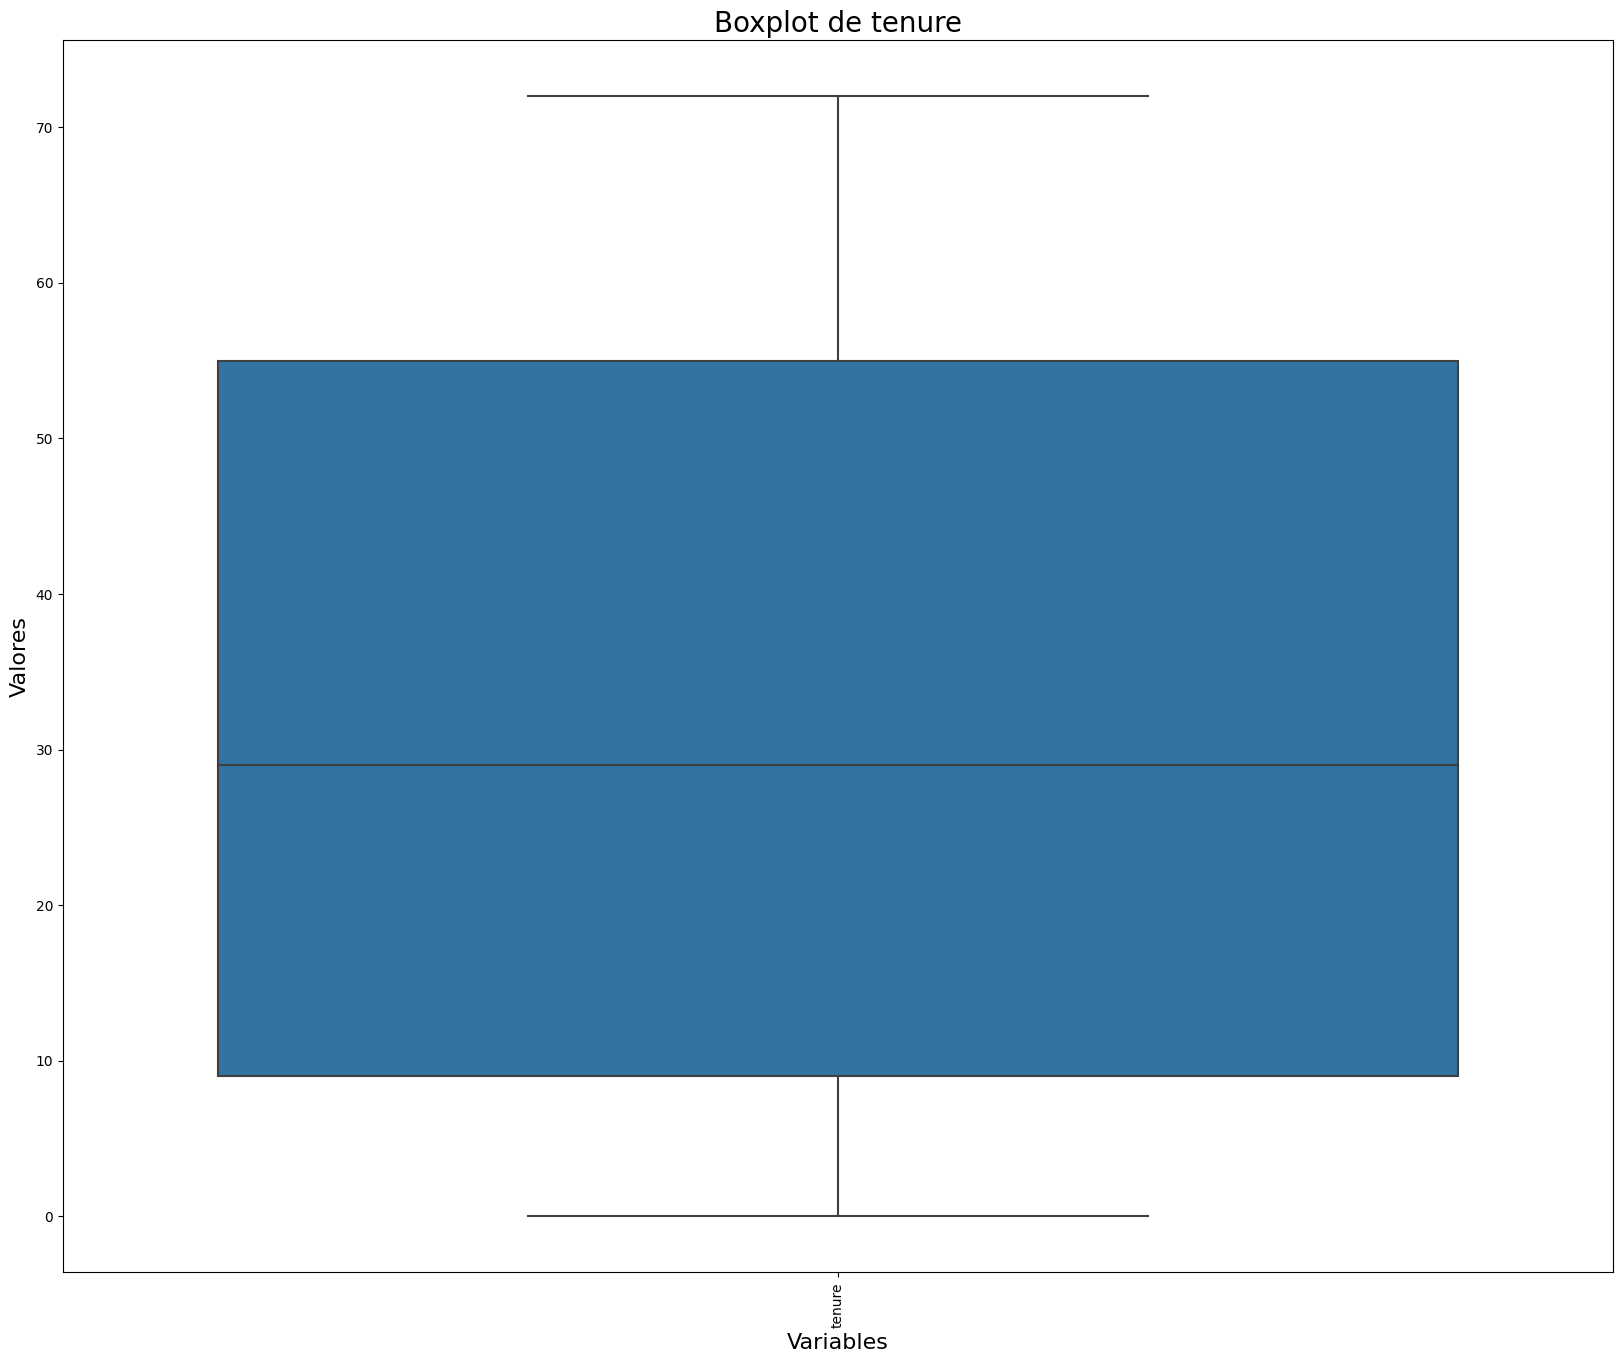

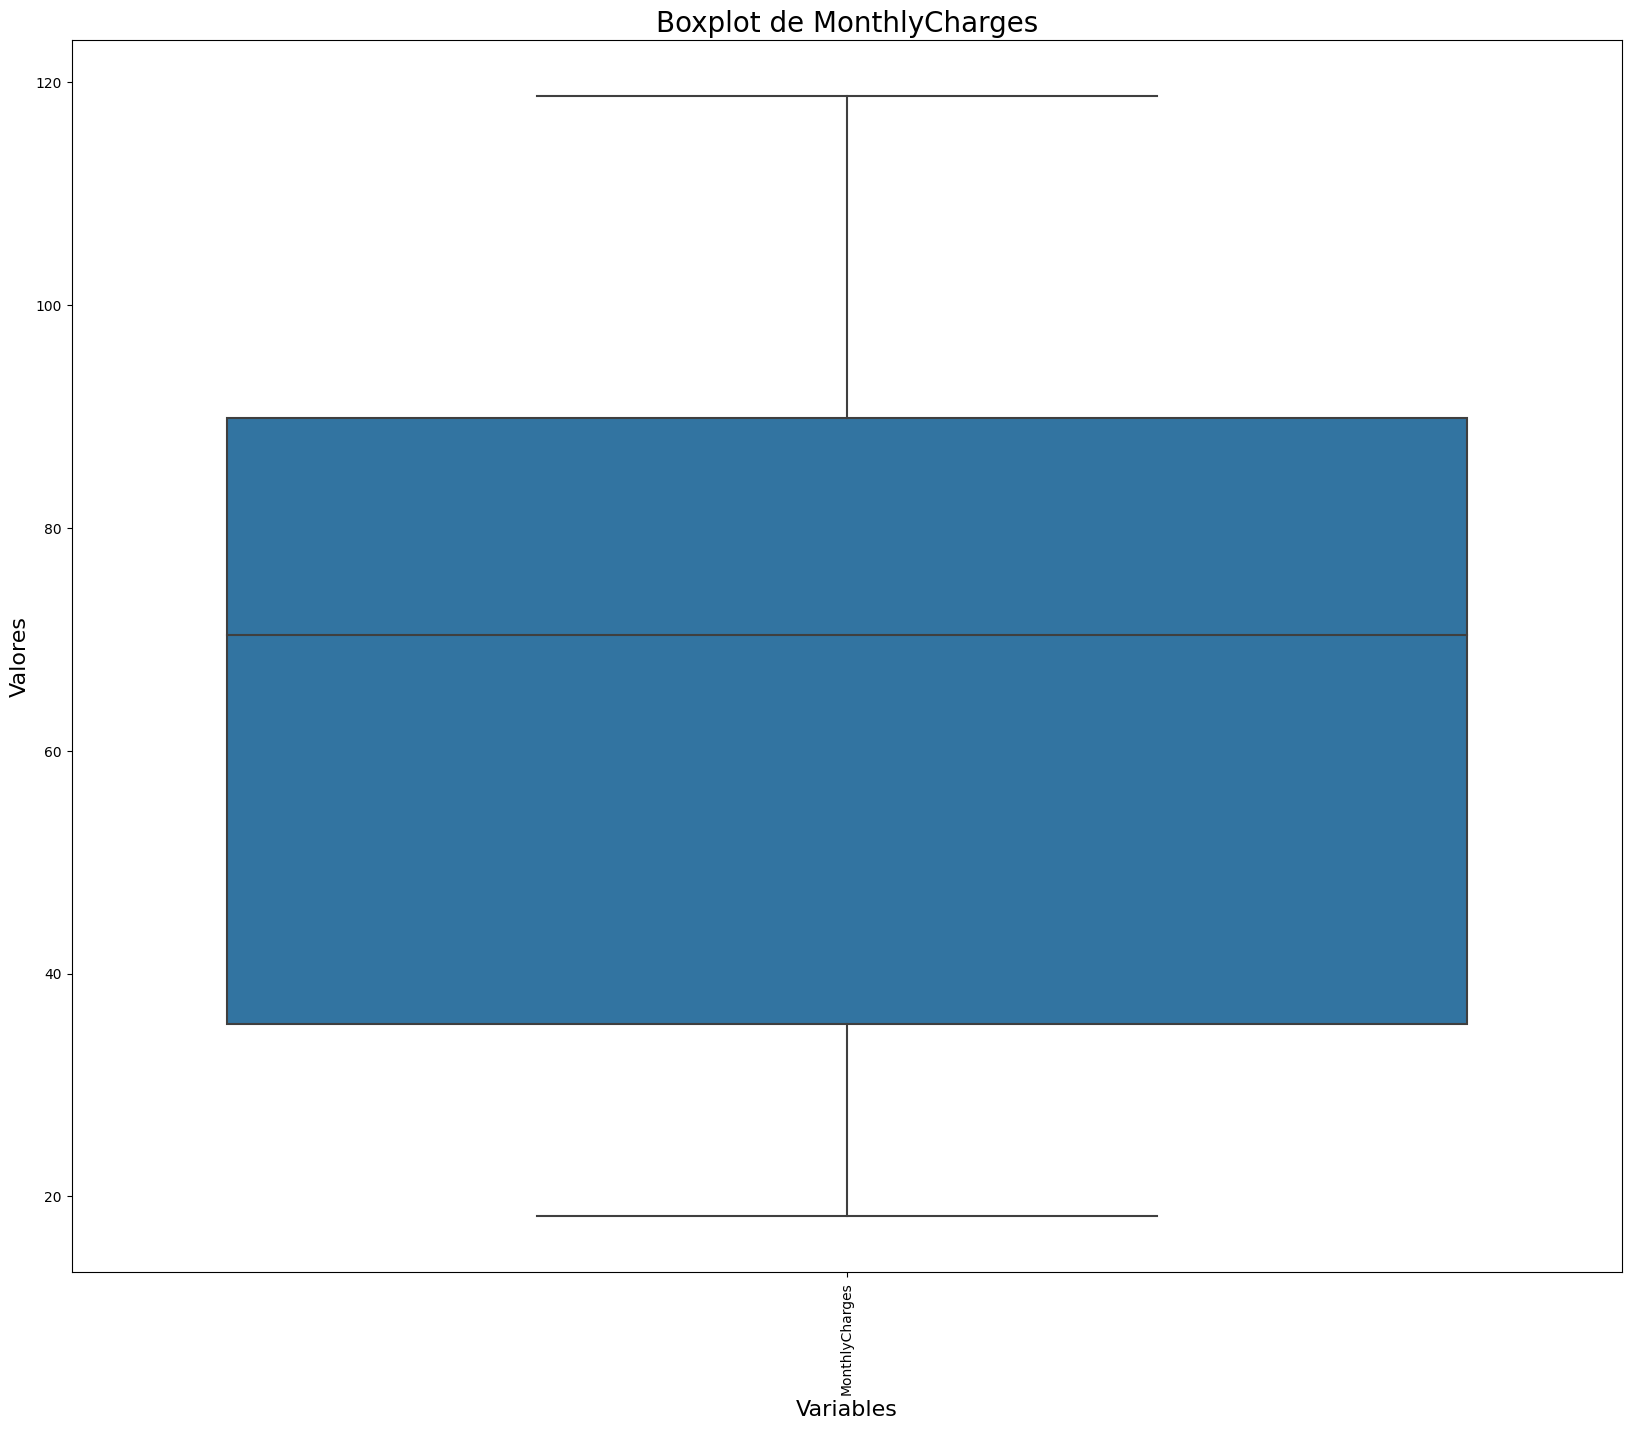

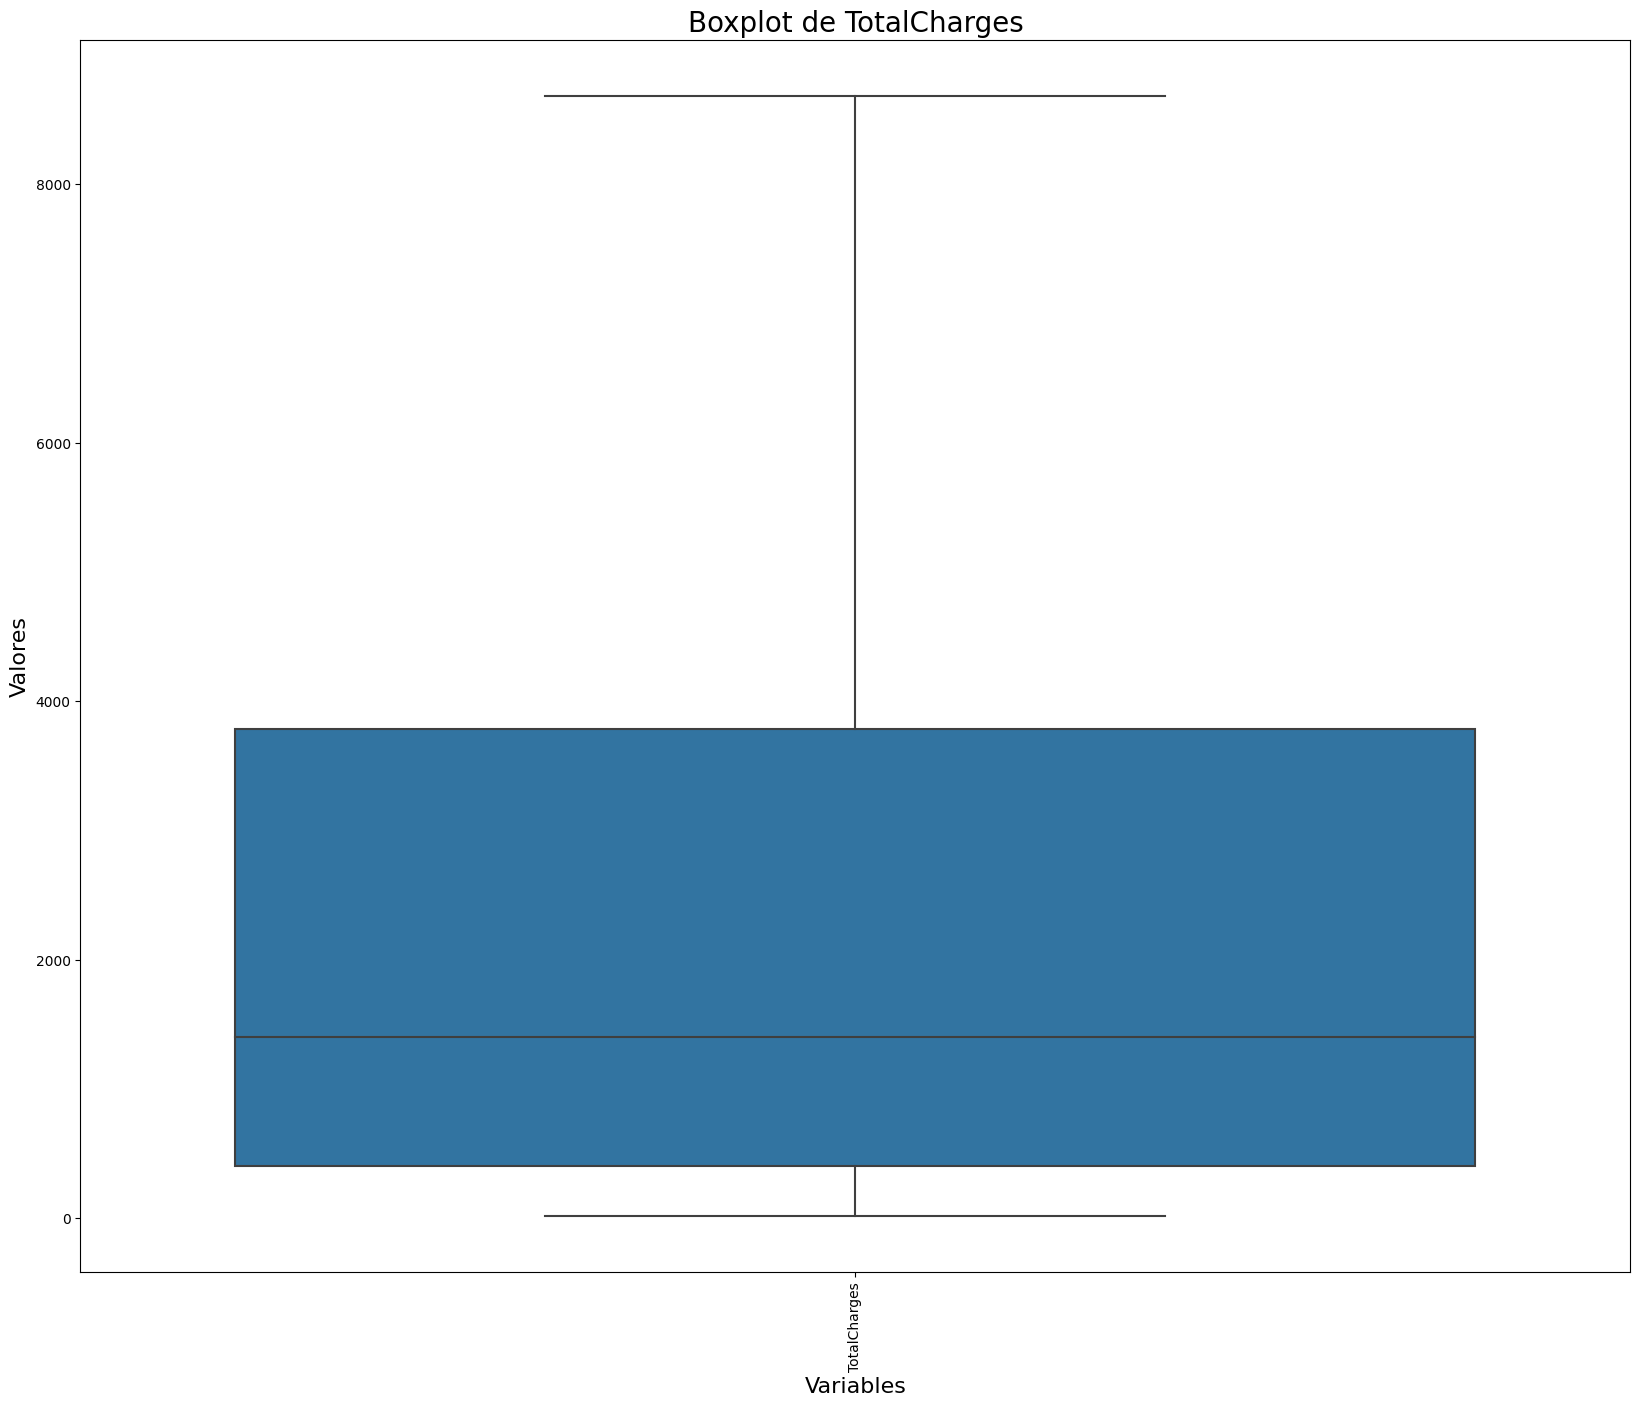

In [17]:
for column in numerical_features:
    plt.figure(figsize=(20, 16))  # Crear una nueva figura para cada plot
    sns.boxplot(data=df[[column]])  # Realizar un boxplot para la columna actual
    plt.title(f'Boxplot de {column}', fontsize=20)  # Personalizar el título con el nombre de la columna
    plt.xlabel('Variables', fontsize=16)
    plt.ylabel('Valores', fontsize=16)
    plt.xticks(rotation=90)  # Es posible que no necesite esta línea, ya que hay solo una variable
    plt.show()  # Mostrar el plot

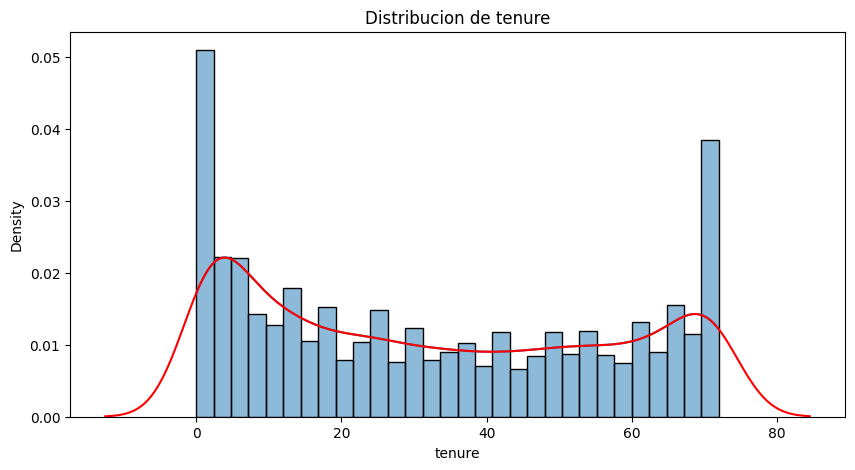

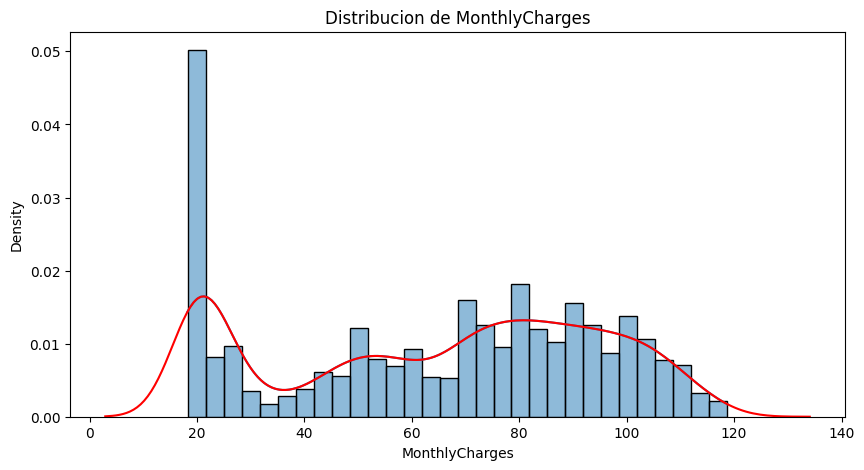

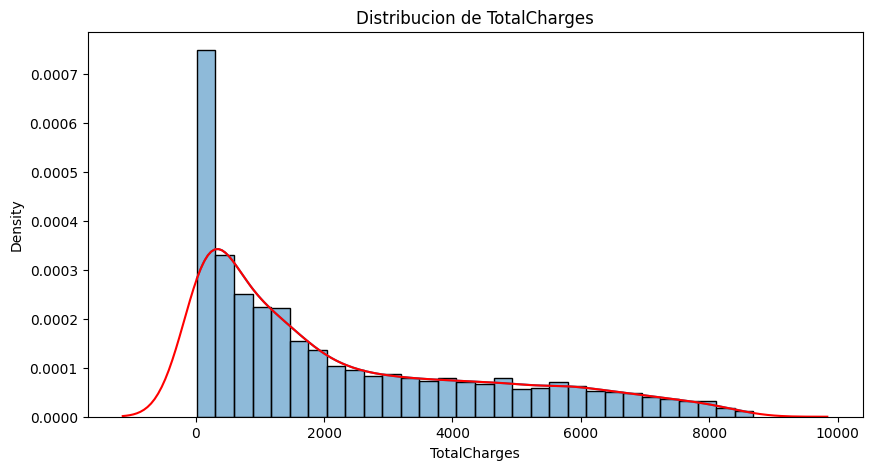

In [18]:
for col in numerical_features:
    plt.figure(figsize=(10, 5))
    plt.title(f'Distribucion de {col}')
    sns.histplot(df[col], bins=30, kde=True, stat='density')
    sns.kdeplot(df[col], color='red')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.savefig(f'density_{col}_plot.png')
    plt.show()

La distribución observada de las variables numéricas tienen las siguientes consideraciones:

En el caso de Tenure, la permanencia con el proveedor de Telco, Tiene una distribución donde las clases modales son la de valor "0" y de valor "72". Son los valores extremos (Mínimo y máximo respectivamente). Esta distribución representa algunos retos, porque el valor de cero meses, altamente representativo, puede sesgar la predicción de la variable objetivo a los "No Churn". Esto porque no se espera que un cliente desista de una suscripción en el mes cero de vinculación.

Por otro lado, la cantidad de valores en 72, hace pensar que la categoría es de 72 meses (6 años) o más, lo que puede impactar tambien el poder predictivo del modelo que se quiera utilizar.

En el caso de los cargos mensuales, la mayoría se encuentra en el valor mínimo, lo que hace pensar que los clientes se decantan por una solución "ligera" del portafolio de servicios ofrecidos por una Telco. Tambien puede representar problemas al momento de darle poder predictivo al modelo.

Finalmente, la distribución de la variable TotalCharges tiene una distribución donde la mayoría de los valores se situan en la intervalo inferior. Esto está marcado porque una proporción alta de clientes paga el fee más bajo y tambien tienen poca permanencia.

De hecho, existe una relación funcional entre estas tres variables que puede impactar el poder predictivo del modelo, y es que la variable "TotalCharges" puede ser una función de "Tenure" que son meses de permanencia y "MonthlyCharges", cargos de facturación mensual.

## Analisis Bi-Variado

### Variables numéricas Vs Churn

Para el ánalisis bivariado, optamos por ver la distribución de las variables numéricas con los rótulos de la variable de respuesta "Churn".

Los resultados son las siguientes:

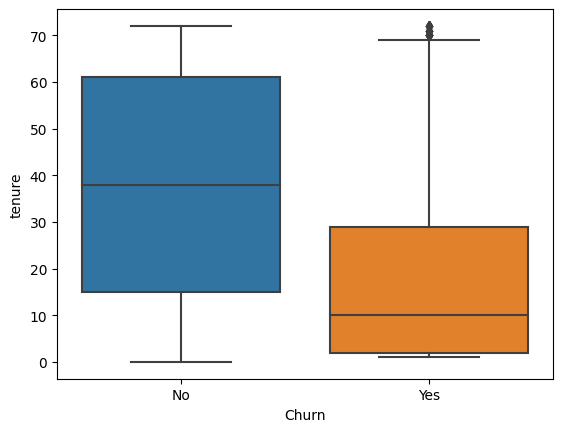

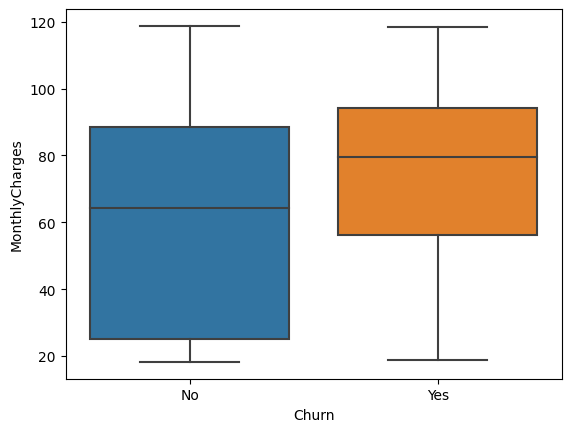

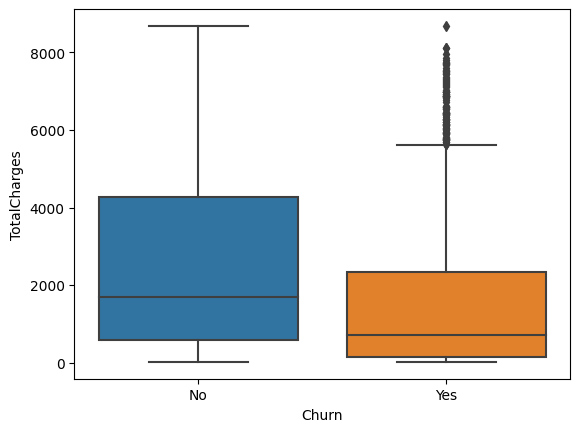

In [19]:
def bivariate_analysis_numerical(df, var_target, var_numerical):
    for col in var_numerical:
        sns.boxplot(x=var_target,y=col,data=df)
        plt.show()

bivariate_analysis_numerical(df,'Churn',numerical_features)

La distribución de estos datos indican lo siguiente:

* Tenure: Los clientes que se desvincularon, tienen un promedio de permanencia menor. Es posible que los clientes que llevan más tiempo vinculados a la empresa tienen menor probabilidad de desistir de su suscripción.

* MonthlyCharges: Los clientes que se desvincularon estaban pagando un fee mayor por la suscripción.

* TotalCharges: Los clientes que se desvincularon tienen un valor más bajo de pagos totales. Esto viene relacionado tambien con el hecho de que en general los clientes que se desvincularon tuvieron menores tiempos de permanencia (Tenure)

Adicionalmente, se presentan histogramas con el método "stack" con el objetivo de verificar la distribución exacta de la variable de salida con las diferentes clases:

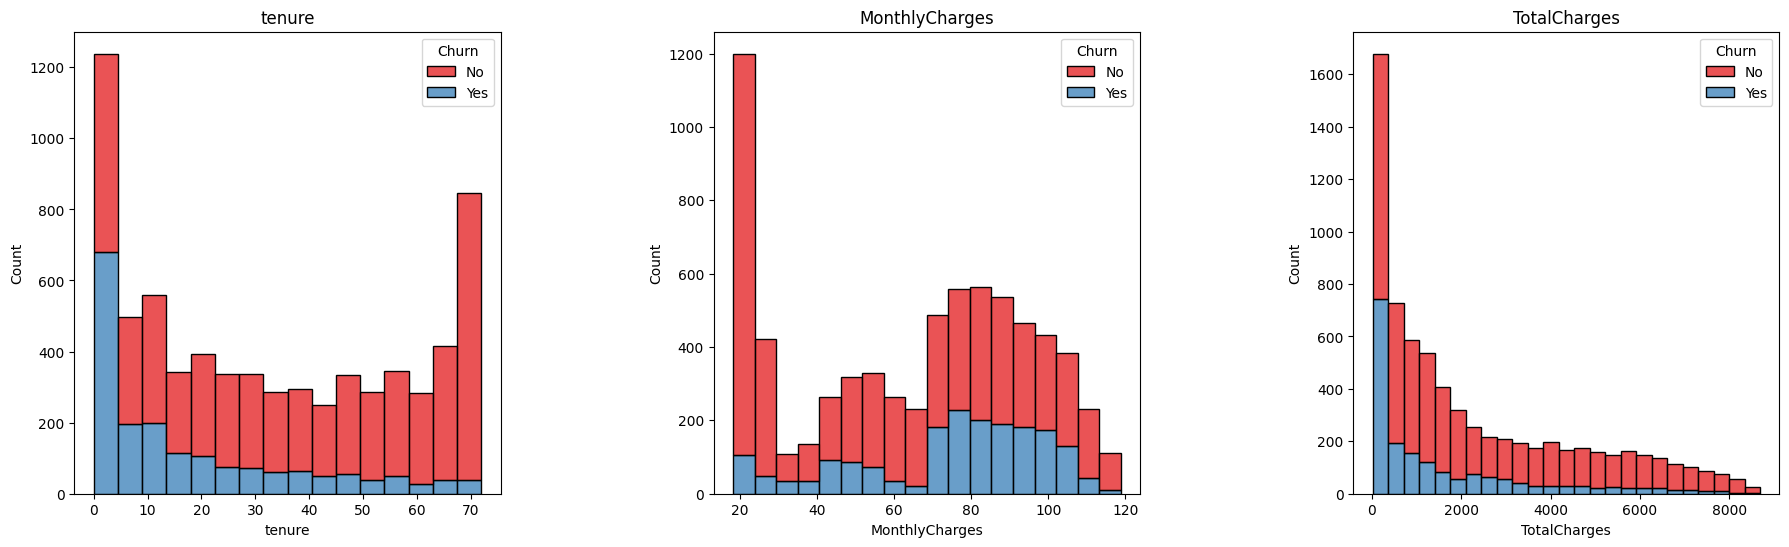

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22, 6), squeeze=False, gridspec_kw={'hspace': 0.5, 'wspace': 0.5})

for i, feature in enumerate(numerical_features):
    row = i // 3  # Calcular el índice de la fila
    col = i % 3   # Calcular el índice de la columna
    sns.histplot(x=df[feature], hue=df['Churn'], multiple="stack", palette="Set1", ax=axes[row, col])
    axes[row, col].set_title(feature)  # Añadir títulos a las subtramas
    plt.savefig("complete_histogram.png")

plt.show()

En el caso de la variable "Tenure" se nota cómo la proporción de "Churn" en Si, es decir, la proporción de clientes que desistieron de su suscripción con la empresa se reduce a medida que aumenta el valor de la variable. De hecho, la menor proporción se observaen el rango mas alto (72 meses).

En el caso de la variable MonthlyCharges se pueden notar que en los rangos de montos bajos de facturación, los clientes que desisten de sus suscripciones son más altos en los rangos de cargos mensuales por encima de 70 USD al mes. No obstante, esa proporción baja para los rangos de tarifas mensuales más altos (Probablemente, por contar con un portafolio más complejo y con servicios variados de valor agregado). Esta conducta es interesante porque se puede establecer que los clientes con cargos mensuales entre los 70 y los 100 dólares, tienen mayor probabilidad de cancelar sus suscripciones y pueden convertirse en un mercado objetivo.

Finalmente, para el caso del total facturado al cliente, la proporción más alta de clientes que abandonan sus suscripciones, se encuentra en el rango de menores conceptos facturados. Esta conducta la justifica la variable "Tenure", dado que se detecta que el efecto de mayor deserción se da en el mes cero. Por lo tanto se compondrá de clientes a los cuales menores valores faturaoss se han generado.

### Variables Categóricas Vs Churn

Para todos los efectos del análisis de datos se continúa con el análisis bivariado entre las variables predictoras categóricas y la variable de respuesta Churn. Para tal efecto se presenta el sigueinte código:

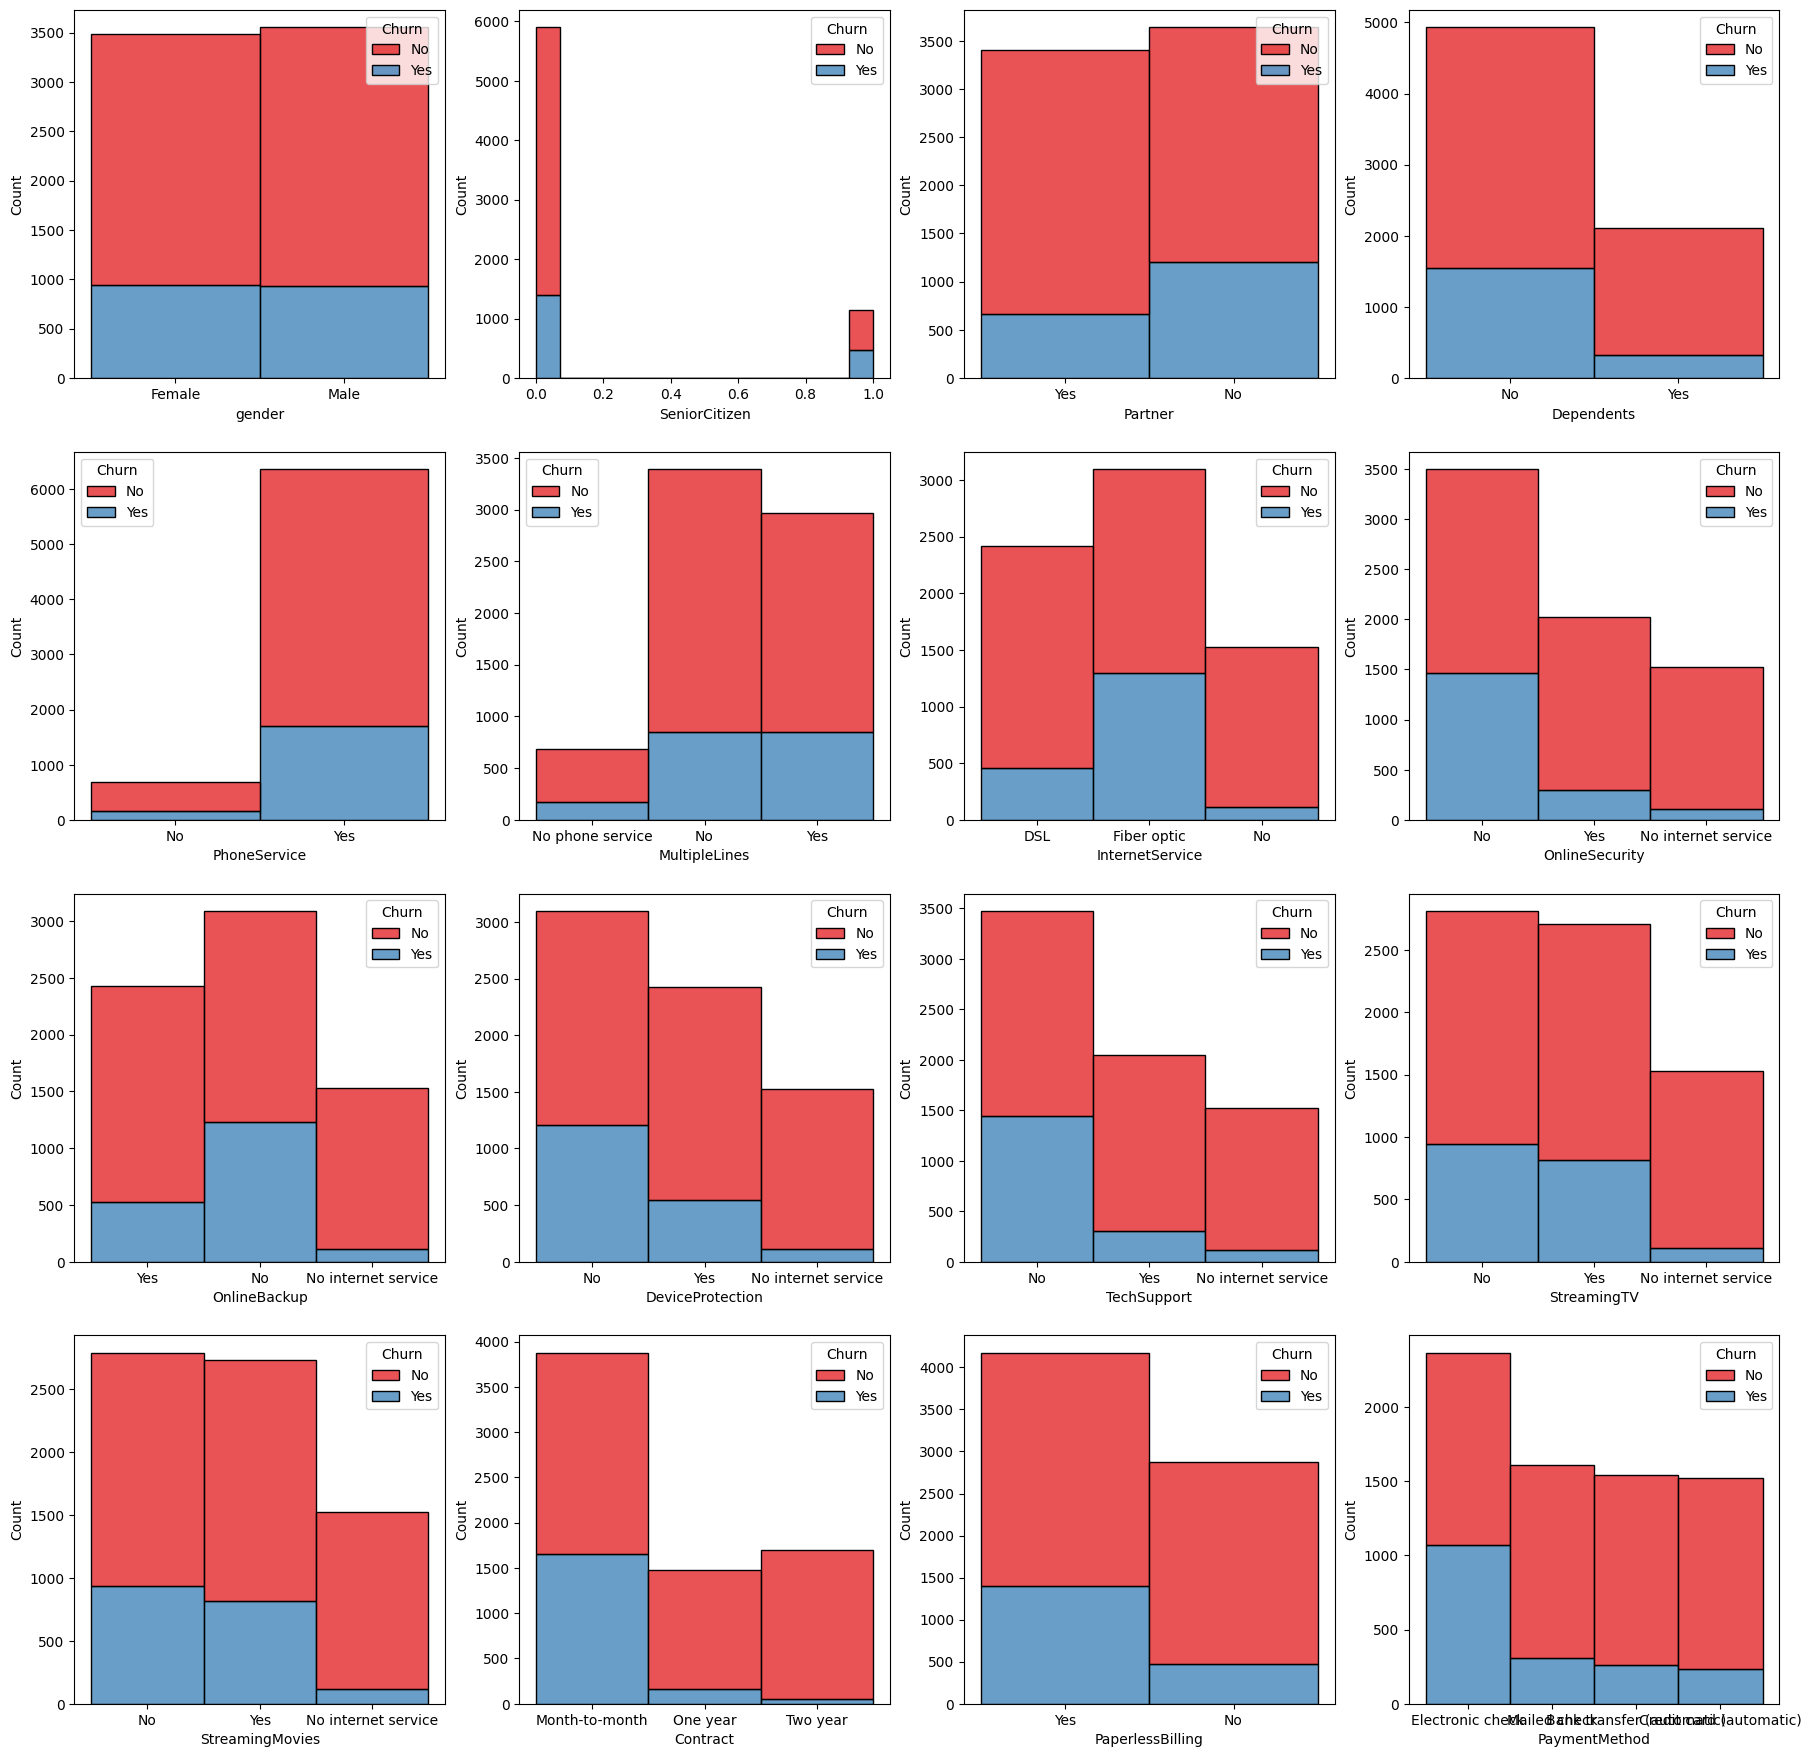

In [21]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(22 , 22), squeeze = True, gridspec_kw=None)
for i, feature in enumerate(categorical_features[:-1]):
    fila = int(i / 4)
    columna = i % 4
    sns.histplot(x = df[feature], hue = df['Churn'], multiple = "stack", palette = "Set1", ax=axes[fila, columna])
plt.savefig("bivariate_cat_histogram.png")

Al respecto, llegamos a las siguientes conclusiones:

* En el caso de gender, no se notan diferencias entre la proporción de clientes que desistieron de sus suscripciones si son hombres o mujeres.

* En el caso de SeniorCitizen, si se encuentran diferentesentre la proporción de clientes que desistieron de sus suscrpciones. De hecho, los adultos mayores desistieron a sus suscripciones a servicios de Telco que quienes no lo son. Se consideraba que podría ser lo contrario, dado que se consideraba que los adultos mayores son más estables en los servicios que contratan.

* En el caso de los suscriptores que no tienen pareja, la proporción de suscriptores que desistieron de sus suscripiones fue más alto que quienes tienen pareja. Posiblemente tiene que ver con la mayor estabilidad que los clientes que tienen pareja tienen respecto a la contratación de este tipo de servicios.

* En el caso de suscriptores con personas a cargo, la proporción de suscriptores que cancelaron sus suscripciones es más alta en el caso de no tener dependientes. Esta conducta puede deberse a la mayor estabilidad en las decisiones que toman los suscriptores que tienen personas a cargo y los vuelven menos propensos a abandonar su actual operador de servicios de Telco.

* Para quienes cuentan con servicio de teléfono, hay una proporcion similar entre quieres desisten del servicio y quienes no lo hacen. No obsatnte, en el caso de quienes tienen multiples líneas, la proporción de desistimiento es mas alta, probablemente porque son clientes que contratan servicios más especializados y pagan más por sus productos. Están en un segmento donde hay más ofertas por parte de las diferentes compañías de telco.

* Para el caso de las empresas que tienen servicio de internet, la proporción de clientes que desisten de su proveedor es mayor para el tipo de servicio de fibra óptica. No obstante en el caso de los servicios de valor agregado, como Seguridad Online, BackUp en línea, protección de dispositivos y soporte técnico, los clientes que no tienen contratados este tipo de servicios tienen mayor proporción en la cantidad de quienes desisten de los servicios de la empresa de Telco. Esto es importante dado que  ofrecer estos servicios de valor agregado a muy bajo precio, puede aumentar la contratación de estos servicios y reducir la rotación de los clientes.

* En el caso de los servicios de streaming tanto para TV como para películas, no se encuentra una diferencia significativa en la proporción de los clientes que desisten de sus suscripciones de quienes tienes estos servicios respecto a quienes lo nos tienen.

* En el caso de los contratos mes a mes, la proporción de clientes que desisten es más alta en comparación con las suscripciones anuales y a dos años. Esto tambien marca dado que marca un interés por parte de las empresas de Telco por mantener suscriptores a uno o dos años.

* Los clientes que no reciben facturas físicas tienen mayor proporción en el grupo de los clientes que desisten respecto a los que no tienen este mecanismo de facturación. Finalmente es más alta la proporción de clientes que desisten de sus suscripciones para el medio de pago "Cheque Electrónico" respecto a los demás medios de pago.

## Variable objetivo - Churn

En el caso de la variable objetivo, de los 7043 observaciones, se encuentra que 1869 de las observaciones fueron de clientes que desistieron de sus suscripciones.

In [22]:
# análisis de variable objetivo
df['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [23]:
balance_ratio = df['Churn'].value_counts(normalize=True)

print("Grado de balanceo del atributo objetivo:")
print(balance_ratio)
print("-----------------------------------------")

fig = px.pie(df, values=df['Churn'].value_counts().values, names=df['Churn'].value_counts().index)
fig.update_traces(textinfo='percent+label', pull=[0.05, 0.05])  # Etiquetas y separación

fig.update_layout(
    title='Pie Chart - "Churn"',
)

fig.write_html("pie_chart.html")

fig.show()

Grado de balanceo del atributo objetivo:
No     0.73463
Yes    0.26537
Name: Churn, dtype: float64
-----------------------------------------


In [24]:
fig = px.histogram(df, x=df['Churn'].value_counts().index, y=df['Churn'].value_counts().values,title='Balance entre las Clases del Atributo Objetivo "Churn"')
fig.update_traces(texttemplate='%{y}', textposition='outside')
fig.update_xaxes(categoryorder='total ascending')

fig.update_layout(
    xaxis_title='Clase',
    yaxis_title='Cantidad',
    showlegend=False
)
fig.show()



# Etapa 2: Prepación de los datos

## codificacion variables categoricas

Para poder utilizar los modelos de predicción, procedemos a codificar las variables categóricas con números para darle una categoría ordinal, utilizando la función label_encoder:

## Balanceo de Datos - Random Over Sampling

Se construye un dataset alternativo balanceado que opcionalmente pueda utilizarse en el entrenamiento y prueba de los modelos que constituyen las hipótesis. El código propuesto es el siguiente:

In [25]:
print(categorical_features[:-1])

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object')


In [26]:
# codificación de variables categóricas
label_encoders = {}

for cate in categorical_features[:-1]:
    le = LE()
    df[cate] = le.fit_transform(df[cate])
    label_encoders[cate] = dict(zip(le.classes_, le.transform(le.classes_)))

for var in categorical_features[:-1]:
    print('---------------------------------------------------')
    print(f'La Variable: {var} tiene este diccionario de codificación:\n')
    print(label_encoders[var])

---------------------------------------------------
La Variable: gender tiene este diccionario de codificación:

{'Female': 0, 'Male': 1}
---------------------------------------------------
La Variable: SeniorCitizen tiene este diccionario de codificación:

{0: 0, 1: 1}
---------------------------------------------------
La Variable: Partner tiene este diccionario de codificación:

{'No': 0, 'Yes': 1}
---------------------------------------------------
La Variable: Dependents tiene este diccionario de codificación:

{'No': 0, 'Yes': 1}
---------------------------------------------------
La Variable: PhoneService tiene este diccionario de codificación:

{'No': 0, 'Yes': 1}
---------------------------------------------------
La Variable: MultipleLines tiene este diccionario de codificación:

{'No': 0, 'No phone service': 1, 'Yes': 2}
---------------------------------------------------
La Variable: InternetService tiene este diccionario de codificación:

{'DSL': 0, 'Fiber optic': 1, 'No':

Verificamos con el método head para verificar que la codificación de variables categóricas fue exitosa:

In [27]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,2,29.85,29.85,No
1,5575-GNVDE,1,0,0,0,34,1,0,0,2,...,2,0,0,0,1,0,3,56.95,1889.50,No
2,3668-QPYBK,1,0,0,0,2,1,0,0,2,...,0,0,0,0,0,1,3,53.85,108.15,Yes
3,7795-CFOCW,1,0,0,0,45,0,1,0,2,...,2,2,0,0,1,0,0,42.30,1840.75,No
4,9237-HQITU,0,0,0,0,2,1,0,1,0,...,0,0,0,0,0,1,2,70.70,151.65,Yes


In [28]:
df1 = df.copy()

In [29]:
df1_majority = df1[df1.Churn == "No"]
df1_minority = df1[df1.Churn == "Yes"]

churn_distribution = df['Churn'].value_counts()

df1_minority_upsampled = resample(df1_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=churn_distribution["No"],    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
df1_upsampled = pd.concat([df1_majority, df1_minority_upsampled])

# Display new class counts
upsampled_churn_distribution = df1_upsampled['Churn'].value_counts()


In [30]:
df1_upsampled.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,2,29.85,29.85,No
1,5575-GNVDE,1,0,0,0,34,1,0,0,2,...,2,0,0,0,1,0,3,56.95,1889.50,No
3,7795-CFOCW,1,0,0,0,45,0,1,0,2,...,2,2,0,0,1,0,0,42.30,1840.75,No
6,1452-KIOVK,1,0,0,1,22,1,2,1,0,...,0,0,2,0,0,1,1,89.10,1949.40,No
7,6713-OKOMC,0,0,0,0,10,0,1,0,2,...,0,0,0,0,0,0,3,29.75,301.90,No


In [31]:
df1_upsampled['Churn'].value_counts()

No     5174
Yes    5174
Name: Churn, dtype: int64

In [32]:
# codificación de variables 'Churn'góricas
label_encoders = {}

le = LE()
df1_upsampled['Churn'] = le.fit_transform(df1_upsampled['Churn'])
label_encoders['Churn'] = dict(zip(le.classes_, le.transform(le.classes_)))

print('---------------------------------------------------')
print(f'La Variable: Churn tiene este diccionario de codificación:\n')
print(label_encoders['Churn'])

---------------------------------------------------
La Variable: Churn tiene este diccionario de codificación:

{'No': 0, 'Yes': 1}


In [33]:
df1_upsampled.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,2,29.85,29.85,0
1,5575-GNVDE,1,0,0,0,34,1,0,0,2,...,2,0,0,0,1,0,3,56.95,1889.50,0
3,7795-CFOCW,1,0,0,0,45,0,1,0,2,...,2,2,0,0,1,0,0,42.30,1840.75,0
6,1452-KIOVK,1,0,0,1,22,1,2,1,0,...,0,0,2,0,0,1,1,89.10,1949.40,0
7,6713-OKOMC,0,0,0,0,10,0,1,0,2,...,0,0,0,0,0,0,3,29.75,301.90,0


## Checkpoint del dataset

In [34]:
df2 = df1_upsampled.copy()

In [35]:
df2.head()
df2.drop(['customerID'], axis=1, inplace=True)

## Normalización bajo el metodo Z-Score

In [39]:
scaler = StandardScaler()
df2[numerical_features] = scaler.fit_transform(df2[numerical_features])
df2.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,-1.104613,0,1,0,0,2,0,0,0,0,0,1,2,-1.318426,-0.914579,0
1,1,0,0,0,0.266577,1,0,0,2,0,2,0,0,0,1,0,3,-0.373981,-0.060953,0
3,1,0,0,0,0.723641,0,1,0,2,0,2,2,0,0,1,0,0,-0.884539,-0.083331,0
6,1,0,0,1,-0.232037,1,2,1,0,2,0,0,2,0,0,1,1,0.746457,-0.033458,0
7,0,0,0,0,-0.730652,0,1,0,2,0,0,0,0,0,0,0,3,-1.321911,-0.789701,0


# Etapa 3: Modelamiento

Se procede a elaborar el código de la modelación y la definición de la muestra de entrenamiento:

In [40]:
def split_data(df, target_column, test_size=0.20, random_state=None):
    """
    Divide un DataFrame en conjuntos de entrenamiento y prueba, y devuelve las características y las etiquetas para ambos conjuntos.

    Parameters:
        df (pd.DataFrame): DataFrame original.
        target_column (str): Nombre de la columna objetivo.
        test_size (float, optional): Proporción del conjunto de prueba. Por defecto es 0.3.
        random_state (int, optional): Semilla aleatoria para reproducibilidad. Por defecto es None.

    Returns:
        tuple: Cuatro DataFrames: X_train, X_test, y_train, y_test.
    """
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

## Split del dataset
80% para el entrenamiento y 20% para la prueba

In [41]:
X_train, X_test, y_train, y_test = train_test_split(df2.drop('Churn', axis=1), df2['Churn'], test_size=0.2, random_state=42)
print(f"Tamaño del conjunto de entrenamiento: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Tamaño del conjunto de prueba: X_test: {X_test.shape}, y_test: {y_test.shape}")

Tamaño del conjunto de entrenamiento: X_train: (8278, 19), y_train: (8278,)
Tamaño del conjunto de prueba: X_test: (2070, 19), y_test: (2070,)


# Modelos

A continuación se definen los parámetros a evaluar en las hipótesis planteadas inicialmente. Los modelos a evaluar para el dataset inicialmente planteado son los siguientes:

* Regresión logística
* Bosque Aleatorio

In [42]:
param_grid_mod1 = {
    'penalty': ['l1','l2'],
    'C': [0.1, 1, 10],
    'solver': ['liblinear']
}

param_grid_mod2 = {
    'n_estimators': [50, 100, 250],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [43]:
models = {
    'LogisticRegression': (LogisticRegression(random_state=42,max_iter=500), param_grid_mod1),
    'RandomForestClassifier': (RandomForestClassifier(random_state=42), param_grid_mod2),   
}

## Busqueda aleatoria de hiperparametros - Grid Search

A continuación se establece la búsqueda aleatoria de los hiperparámetros de cada modelo a partir de Grid Search. Se plantea un esquema de validacion con 10 folds, con el objetivo de tener una mejor estimación de los hiperparámetros que mejor se ajustan a los modelos planteados.

In [45]:
# DataFrame para almacenar los resultados
columns = ['Modelo', 'Número de iteraciones', 'Mejor accuracy', 'Tiempo empleado']
results_grid = pd.DataFrame(columns=columns)

# Realizando la búsqueda en cuadrícula para cada modelo
for model_name, (model, param_grid) in tqdm(models.items()):
    gs = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=10,
                    n_jobs=-1,
                    verbose=2)
    print(f"Realizando Grid Search para el modelo {model_name}...")
    # Medir el tiempo de ejecución
    time_start = time.time()
    gs.fit(X_train, y_train)
    time_grid = time.time() - time_start

    values_grid  = [model_name, len(gs.cv_results_['params']), gs.best_score_, time_grid]
    result_df    = pd.DataFrame([values_grid], columns=columns)
    results_grid = pd.concat([results_grid, result_df], ignore_index=True)
    print('El resultado del modelo es: ', gs.best_score_)

# Visualizar los resultados
print("Resultados de Grid Search:")
print(results_grid)

  0%|          | 0/2 [00:00<?, ?it/s]

Realizando Grid Search para el modelo LogisticRegression...
Fitting 10 folds for each of 6 candidates, totalling 60 fits


 50%|█████     | 1/2 [00:00<00:00,  1.30it/s]

El resultado del modelo es:  0.7674508876154426
Realizando Grid Search para el modelo RandomForestClassifier...
Fitting 10 folds for each of 81 candidates, totalling 810 fits


100%|██████████| 2/2 [02:25<00:00, 72.78s/it]

El resultado del modelo es:  0.8953850714707137
Resultados de Grid Search:
                   Modelo Número de iteraciones  Mejor accuracy  \
0      LogisticRegression                     6        0.767451   
1  RandomForestClassifier                    81        0.895385   

   Tiempo empleado  
0         0.765114  
1       144.789281  


## Busqueda aleatoria de hiperparametros - Random Search

A continuación se establece la búsqueda aleatoria de los hiperparámetros de cada modelo

In [46]:
# DataFrame para almacenar los resultados
columns = ['Modelo', 'Número de iteraciones', 'Mejor accuracy', 'Tiempo empleado']
results_grid = pd.DataFrame(columns=columns)

# Realizando la búsqueda aleatoria para cada modelo
for model_name, (model, param_grid) in tqdm(models.items()):
    rs = RandomizedSearchCV(estimator=model,
                            param_distributions=param_grid,
                            scoring='f1_weighted',
                            cv=10,
                            n_jobs=-1,
                            verbose=2,
                            n_iter=400)
    print(f"Realizando Random Search para el modelo {model_name}...")
    # Medir el tiempo de ejecución
    time_start = time.time()
    rs.fit(X_train, y_train)
    time_grid = time.time() - time_start

    # Almacenar los resultados
    values_grid  = [model_name, len(rs.cv_results_['params']), rs.best_score_, time_grid]
    result_df    = pd.DataFrame([values_grid], columns=columns)
    results_grid = pd.concat([results_grid, result_df], ignore_index=True)
    print(f'El resultado del modelo {model_name} es: ', rs.best_score_)
# Visualizar los resultados
print("Resultados de Random Search:")
print(results_grid)

  0%|          | 0/2 [00:00<?, ?it/s]c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning:

The total space of parameters 6 is smaller than n_iter=400. Running 6 iterations. For exhaustive searches, use GridSearchCV.



Realizando Random Search para el modelo LogisticRegression...
Fitting 10 folds for each of 6 candidates, totalling 60 fits


 50%|█████     | 1/2 [00:00<00:00,  1.10it/s]

El resultado del modelo LogisticRegression es:  0.7668774237169762
Realizando Random Search para el modelo RandomForestClassifier...
Fitting 10 folds for each of 81 candidates, totalling 810 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning:

The total space of parameters 81 is smaller than n_iter=400. Running 81 iterations. For exhaustive searches, use GridSearchCV.

100%|██████████| 2/2 [02:24<00:00, 72.38s/it]

El resultado del modelo RandomForestClassifier es:  0.8951001905560076
Resultados de Random Search:
                   Modelo Número de iteraciones  Mejor accuracy  \
0      LogisticRegression                     6        0.766877   
1  RandomForestClassifier                    81        0.895100   

   Tiempo empleado  
0         0.904287  
1       143.856445  


Los resultados observados son similares que los obtenidos bajo el método de Grid Search.

## Busqueda bayesiana de hiperparametros - Bayes Search

In [ ]:
# Se instala la librería requerida
#!pip install scikit-optimize

In [48]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [50]:
# DataFrame para almacenar los resultados
columns = ['Modelo', 'Número de iteraciones', 'Mejor accuracy', 'Tiempo empleado']
results_grid = pd.DataFrame(columns=columns)

# Realizando la búsqueda aleatoria para cada modelo
for model_name, (model, param_grid) in tqdm(models.items()):
    bs = BayesSearchCV(estimator=model,
                        search_spaces=param_grid,
                        scoring='accuracy',
                        cv=10,
                        n_jobs=-1,
                        verbose=2,
                        n_iter=50)
    print(f"Realizando Bayes Search para el modelo {model_name}...")
    # Medir el tiempo de ejecución
    time_start = time.time()
    bs.fit(X_train, y_train)
    time_grid = time.time() - time_start

    # Almacenar los resultados
    values_grid  = [model_name, len(bs.cv_results_['params']), bs.best_score_, time_grid]
    result_df    = pd.DataFrame([values_grid], columns=columns)
    results_grid = pd.concat([results_grid, result_df], ignore_index=True)
    print('El resultado del modelo es: ', bs.best_score_)

  0%|          | 0/2 [00:00<?, ?it/s]

Realizando Bayes Search para el modelo LogisticRegression...
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


 50%|█████     | 1/2 [00:54<00:54, 54.33s/it]

El resultado del modelo es:  0.7674508876154426
Realizando Bayes Search para el modelo RandomForestClassifier...
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 ca

c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


100%|██████████| 2/2 [03:04<00:00, 92.19s/it]

El resultado del modelo es:  0.8953850714707137


## Resultados Grid Search

| Modelo | Iter | Accuracy Grid Search | Tiempo empleado (s)|
|--------|:---------:|:---------:|:---------:|
| LogisticRegression     |6|0.767451 |0.765114|
| RandomForestClassifier |81|0.895385|144.789281|

## Resultados Random Search

| Modelo | Iter | Accuracy Random Search | Tiempo empleado (s)|
|--------|:---------:|:---------:|:---------:|
| LogisticRegression     |6|0.766877|0.904287|
| RandomForestClassifier |81|0.895100|143.856445|


## Resultados Bayes Search

| Modelo | Iter | Accuracy Bayes Search | Tiempo empleado (s)|
|--------|:---------:|:---------:|:---------:|
| LogisticRegression     |-|0.767450|54|
| RandomForestClassifier |-|0.89538|184|

Pendiente

## Modelo 1 - Utilización de las métricas de evaluación adecuadas

In [67]:
param_grid_mod1 = {
    'penalty': ['l1','l2'],
    'C': [0.1, 1, 10],
    'solver': ['liblinear']
}
models = {
    'LogisticRegression': (LogisticRegression(random_state=42,max_iter=500), param_grid_mod1),
}

# DataFrame para almacenar los resultados
columns = ['Modelo', 'Número de iteraciones', 'Mejor accuracy', 'Tiempo empleado']
results_grid = pd.DataFrame(columns=columns)

# Realizando la búsqueda en cuadrícula para cada modelo
for model_name, (model, param_grid) in tqdm(models.items()):
    gslr = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=10,
                    n_jobs=-1,
                    verbose=2)
    print(f"Realizando Grid Search para el modelo {model_name}...")
    # Medir el tiempo de ejecución
    time_start = time.time()
    gslr.fit(X_train, y_train)
    time_grid = time.time() - time_start

    values_grid  = [model_name, len(gslr.cv_results_['params']), gslr.best_score_, time_grid]
    result_df    = pd.DataFrame([values_grid], columns=columns)
    results_grid = pd.concat([results_grid, result_df], ignore_index=True)
    print('El resultado del modelo es: ', gslr.best_score_)

# Visualizar los resultados
print("Resultados de Grid Search:")
print(results_grid)

  0%|          | 0/1 [00:00<?, ?it/s]

Realizando Grid Search para el modelo LogisticRegression...
Fitting 10 folds for each of 6 candidates, totalling 60 fits


100%|██████████| 1/1 [00:03<00:00,  3.34s/it]

El resultado del modelo es:  0.7674508876154426
Resultados de Grid Search:
               Modelo Número de iteraciones  Mejor accuracy  Tiempo empleado
0  LogisticRegression                     6        0.767451         3.339637


In [70]:
print("Los parametros de Logistic Regression con GridSearch son: ", gslr.best_params_) 

Los parametros de Logistic Regression con GridSearch son:  {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


In [71]:
lr = LogisticRegression(**gslr.best_params_)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.73      0.76      1044
           1       0.75      0.81      0.78      1026

    accuracy                           0.77      2070
   macro avg       0.77      0.77      0.77      2070
weighted avg       0.77      0.77      0.77      2070



c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



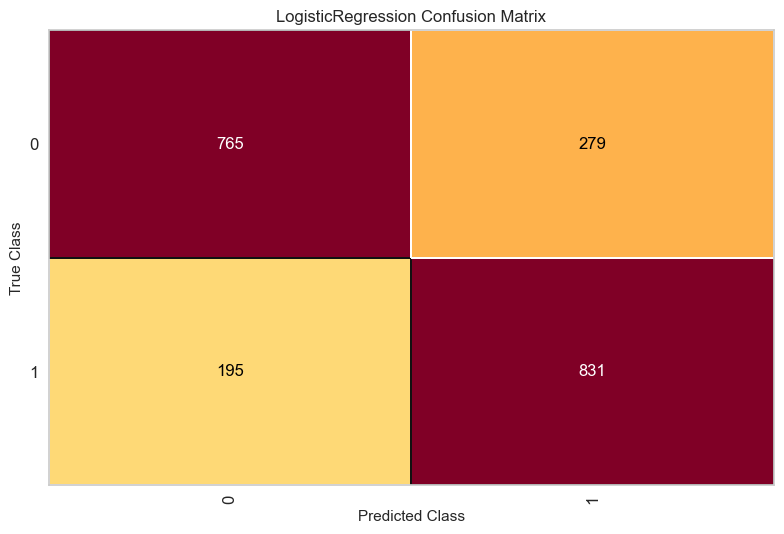

<AxesSubplot: title={'center': 'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [72]:
cm = ConfusionMatrix(lr, classes=[0,1])
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



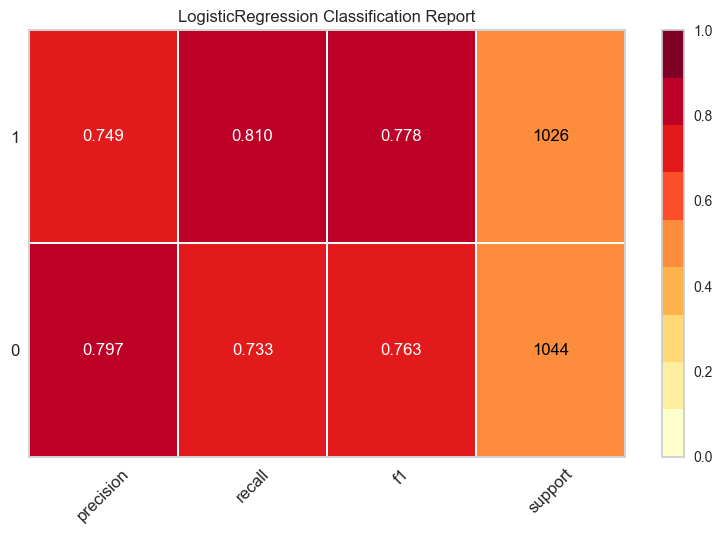

<AxesSubplot: title={'center': 'LogisticRegression Classification Report'}>

In [73]:
visualizer = ClassificationReport(lr, support=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



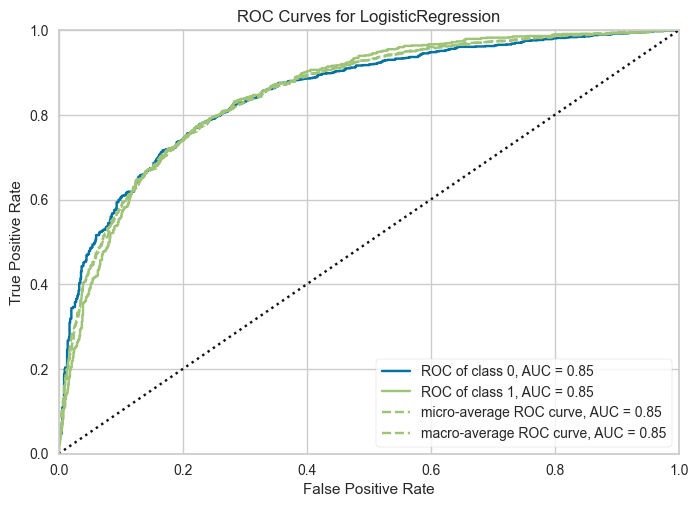

<AxesSubplot: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [74]:
visualizer = ROCAUC(lr)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

## Modelo 2- Utilización de las métricas de evaluación adecuadas

In [58]:
# Random Forest
print("Los parametros de Random Forest con GridSearch son: ", gs.best_params_) 
print("Los parametros de Random Forest con RandomSearch son: ", rs.best_params_)
print("Los parametros de Random Forest con BayesSearch son: ", bs.best_params_)

Los parametros de Random Forest con GridSearch son:  {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Los parametros de Random Forest con RandomSearch son:  {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Los parametros de Random Forest con BayesSearch son:  OrderedDict([('max_depth', 30), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 50)])


In [59]:
rf = RandomForestClassifier(**gs.best_params_)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91      1044
           1       0.89      0.95      0.92      1026

    accuracy                           0.91      2070
   macro avg       0.92      0.92      0.91      2070
weighted avg       0.92      0.91      0.91      2070



c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



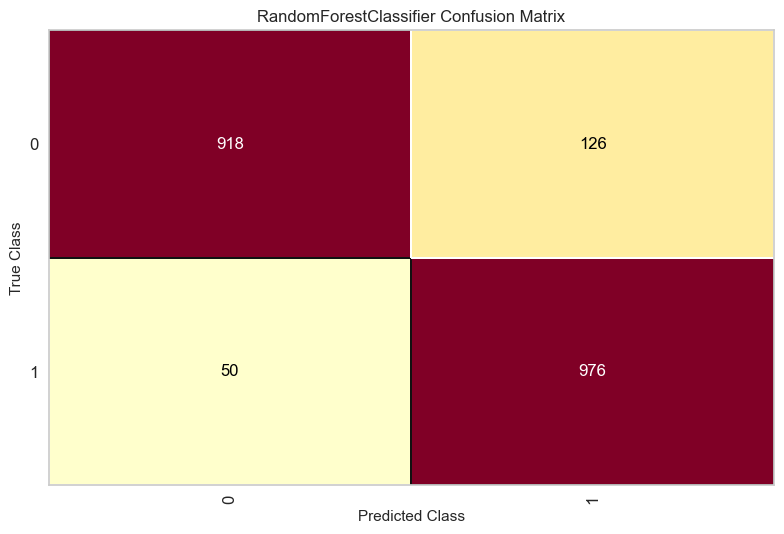

<AxesSubplot: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [65]:
cm = ConfusionMatrix(rf, classes=[0,1])
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



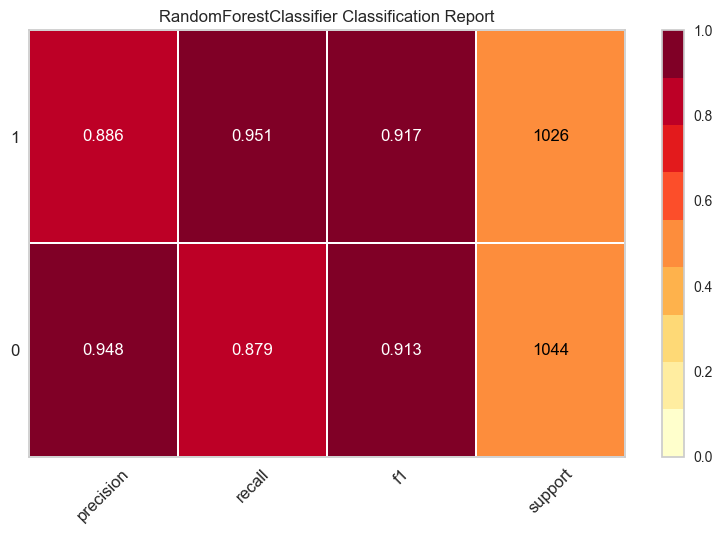

<AxesSubplot: title={'center': 'RandomForestClassifier Classification Report'}>

In [64]:
visualizer = ClassificationReport(rf, support=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

c:\Users\hamso\anaconda3\envs\pycaret3\lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



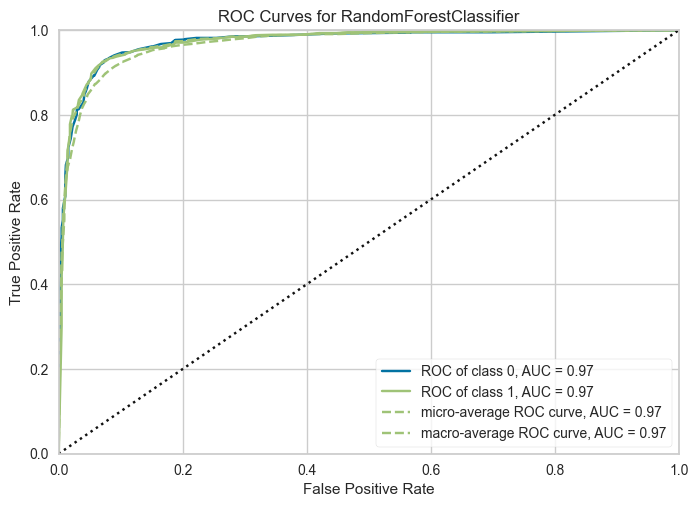

<AxesSubplot: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [66]:
visualizer = ROCAUC(rf)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

## Conclusiones

Pendiente